# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

In [1]:
import cv2
from matplotlib import pyplot as plt
from scipy import ndimage
import numpy as np
import math
import os
import requests

def get_file(url_path, filename):
    if not os.path.exists(filename):
        url = url_path
        r = requests.get(url, allow_redirects=True)
        open(filename, 'wb').write(r.content)

get_file('https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png', 'dom.png')

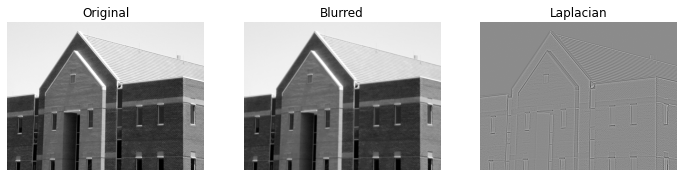

In [2]:
#1 
house = cv2.imread('dom.png', cv2.IMREAD_GRAYSCALE)

#2
blurred = cv2.GaussianBlur(house, (3,3), 0)

#3
laplacian = cv2.Laplacian(blurred, cv2.CV_32F)

fig, axs = plt.subplots(1,3)
images = [house, blurred, laplacian]
titles = ["Original", "Blurred", "Laplacian"]
for i in range(len(images)):
    axs[i].imshow(images[i], 'gray')
    axs[i].axis('off')
    axs[i].set_title(titles[i])
fig.set_size_inches(12, 10)
plt.show()

In [3]:
def get_laplacian(img, size, sigma):
    blurred = cv2.GaussianBlur(img, (size, size), sigma)
    return cv2.Laplacian(blurred, cv2.CV_32F)

In [4]:
#4
def crossing(img, thr): #img == LoG
    result = np.zeros(img.shape)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            surr = img[i-1: i+2, j-1: j+2]
            min_value, max_value = np.min(surr), np.max(surr)
            if min_value*max_value < 0:
                if img[i][j] > 0:
                    result[i][j] = img[i][j] + abs(min_value)
                else:
                    result[i][j] = abs(img[i][j]) + max_value
    result = (result*255/np.max(result)).astype(int)
    result = np.where(result <= thr, 0, 255).astype('uint8')
    result = cv2.medianBlur(result, 3)
    return result

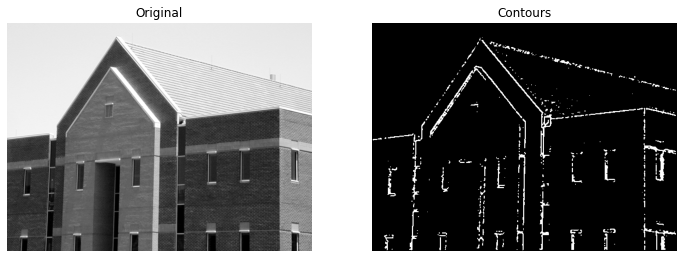

In [5]:
log = get_laplacian(house, 9, 0)
contoured = crossing(log, 60)

images = [house, contoured]
titles = ["Original", "Contours"]
fig, axs = plt.subplots(1, len(images))
for i in range(len(images)):
    axs[i].imshow(images[i], 'gray')
    axs[i].axis('off')
    axs[i].set_title(titles[i])
fig.set_size_inches(12, 10)
plt.show()

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w 1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj algorytm detekcji krawędziCanny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Dlatego wykorzystuje się obraz $g_{NL}$ w następującej procedurze:
    - Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
    - Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
    - Stwórz obraz, któy zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
    - Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź (potencjalną).
        Można to wykoanać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować wbardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj algorytm Cannego.

In [6]:
def canny(img, filter_size, sigma, high_threshold, ratio):
    #1
    blurred = cv2.GaussianBlur(img, (filter_size, filter_size), sigma)
    
    #2
    g_x = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=3)
    g_y = cv2.Sobel(blurred, cv2.CV_32F, 0, 1, ksize=3)
    
    M, angles = cv2.cartToPolar(g_x, g_y, angleInDegrees = True) 
    result = M.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):  
            angle = angles[i][j]
            
            if angle <= 22.5 or 337.5 < angle or 157.5 < angle <= 157.5 + 45.0: #poziomy
                n1, n2 = (i, j-1), (i, j+1)
            elif 22.5 < angle <= 22.5 + 45 or 157.5 + 45.0 < angle <= 157.5 + 90.0: #skośny prawy
                n1, n2 = (i-1, j-1), (i+1, j+1)
            elif 22.5 + 45.0 < angle <= 22.5 + 90.0 or 157.5 + 90.0 < angle <= 157.5 + 135.0: #pion
                n1, n2 = (i-1, j), (i+1, j)
            else: #skośny lewy
                n1, n2 = (i+1, j-1), (i-1, j+1)
            
            if 0 <= n1[0] < img.shape[0] and 0 <= n1[1] < img.shape[1]:
                if M[i, j] < M[n1[0], n1[1]]:
                    result[i,j] = 0
            if 0 <= n2[0] < img.shape[0] and 0 <= n2[1] < img.shape[1]:
                if M[i, j] < M[n2[0], n2[1]]:
                    result[i,j] = 0
                    
    tH = high_threshold
    tL = tH/ratio
    
    result_high = np.where(result >= tH, result, 0)
    result_low = np.where((tL <= result) & (result < tH), 1, 0)
        
    visited = np.zeros(img.shape)
    points = [(i, j) for i in range(img.shape[0]) for j in range(img.shape[1]) if result_high[i,j]]
    edges = np.zeros_like(img)
    
    while points:
        point = points.pop()
        if visited[point[0], point[1]]:
            continue
        visited[point[0], point[1]] = 1
        edges[point[0], point[1]] = 1
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0: continue
                if 0 <= point[0] + i < img.shape[0] and 0 <= point[1] + j < img.shape[1]:
                    if result_low[point[0]+i, point[1]+j]:
                        points.append((point[0]+i, point[1]+j))
    return edges

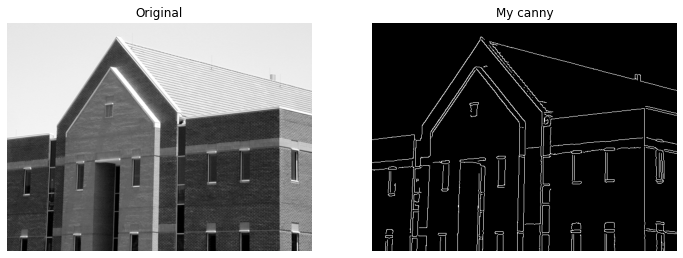

In [7]:
my_canny = canny(house, 7, 0, 70, 2)

images = [house, my_canny]
titles = ["Original", "My canny"]
fig, axs = plt.subplots(1,2)
fig.set_size_inches(12, 10)
for i in range(len(images)):
    axs[i].imshow(images[i], 'gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')
plt.show()

## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z własną implementacją.

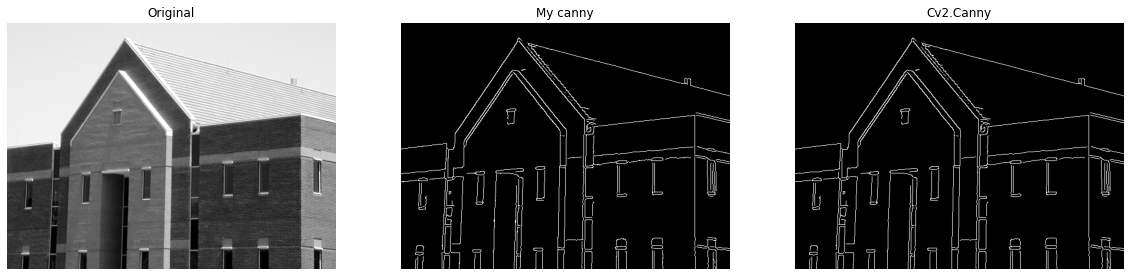

In [11]:
lower_thr = 35
higher_thr = lower_thr*2
blurred = cv2.GaussianBlur(house, (7, 7), 0)
lib_canny = cv2.Canny(blurred, lower_thr, higher_thr, None, 3, 1)

fig, axs = plt.subplots(1, 3)
images = [house, my_canny, lib_canny]
titles = ["Original", "My canny", "Cv2.Canny"]

for i, el in enumerate(images):
    axs[i].imshow(el, 'gray')
    axs[i].axis('off')
    axs[i].set_title(titles[i])

fig.set_size_inches(20,10)
plt.show()